In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import yaml
from fredapi import Fred
import functs as auxfun
import statsmodels.api as sm
from statsmodels.tsa.api import VAR

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) # Ignore future warnings...

# Load config file
with open('config.yaml', 'r') as file:
    config = yaml.safe_load(file)
download_data=False

if download_data==True:
    # Download data
    api_key = config['api_key']
    fred = Fred(api_key=config['api_key'])

    var_list = config['data_series'].keys()
    all_variables = config['data_series']

    df = pd.DataFrame()
    try:
        if config['real_time']:
            
            for variable in var_list:
                try:
                    if all_variables[variable]['revision'] == 'get_rate':
                            print('Now downloading variable: ' + variable + ', which is real time in rates.')
                    
                    # basic scheme... # this is PERIOD OVER PERIOD
                    df_aux = fred.get_series_first_release(all_variables[variable]['code'])
                    df_aux.index = pd.DatetimeIndex(pd.to_datetime(df_aux.index), freq='MS')
                    df_aux.sort_index(ascending=True)
                    df_aux = 100 * (df_aux-df_aux.shift(1))/df_aux.shift(1)

                    dates_to_download = fred.get_series_vintage_dates(all_variables[variable]['code'])
                    for date in dates_to_download:
                        datestr = date.strftime('%m-%d-%Y')
                        print('Now downloading: ' + datestr)
                        df_aux2 = fred.get_series_as_of_date(all_variables[variable]['code'], datestr)
                        df_aux[pd.to_datetime(df_aux2.iloc[-1].date)] = 100 * (df_aux2.iloc[-1].value - df_aux2.iloc[-2].value)/(df_aux2.iloc[-2].value)

                    df_aux.index = pd.to_datetime(df_aux.index)
                    df_aux.sort_index(ascending=True)
                    try:
                        df_aux.index = pd.DatetimeIndex(df_aux.index, freq='MS')
                    except:
                        df_aux.index = pd.DatetimeIndex(df_aux.index)# + pd.DateOffset(months=1)
                    df_aux.sort_index(ascending=True)
                    df_aux.name = variable
                    df = pd.concat((df, df_aux),axis=1)

                except:
                    print('Now downloading variable: ' + variable)
                    df_aux = fred.get_series_first_release(all_variables[variable]['code'])
                    df_aux.index = pd.to_datetime(df_aux.index)
                    df_aux.sort_index(ascending=True)
                    try:
                        df_aux.index = pd.DatetimeIndex(df_aux.index, freq='MS')
                    except:
                        df_aux.index = pd.DatetimeIndex(df_aux.index)# + pd.DateOffset(months=1)
                    df_aux.sort_index(ascending=True) # Just making sure
                    df_aux.name = variable
                    df = pd.concat((df, df_aux),axis=1)
    except:
        for variables in var_list:
            df_aux = fred.get_series(all_variables[variable]['code'])
            df_aux.index = pd.to_datetime(df_aux.index)
            df_aux.sort_index(ascending=True)
            df_aux.index = pd.DatetimeIndex(df_aux.index, freq='MS')
            df_aux.name = variable
            df = pd.concat((df, df_aux),axis=1)

    sample_start = pd.to_datetime(config['sample_start'])
    df = auxfun.transform_data(df, all_variables, sample_start=sample_start)


else:
    df = pd.read_csv('df_downloaded.csv').set_index('date')
    df.index = pd.to_datetime(df.index)
    df = df.loc[df.index.year<=2024]

In [ ]:
df_y = df.loc[:, ['unemployment', 'core_pce_inf', 'core_pce_real']]
df_x = df.loc[:, ['unemployment', 'cbo_unemployment']].shift(1)
df_x = df_x.ffill().bfill()
df_x = df_x.iloc[:,0] - df_x.iloc[:,1]
c = df_x.copy()
df_x = (df_x>=0)*1*(df_x)
df_x = df_x.shift(1).fillna(0)
df_x = pd.concat((df_x,
                  df.loc[:, 'consumer_sentiment'],
                  df.loc[:, 'consumer_sentiment']*df_x,
                  df.loc[:, 'interest']),axis=1)

In [72]:
# With the differential
model = VAR(df_y.iloc[:-20], exog=df_x.iloc[:-20])
mf = model.fit(12)
ff = mf.forecast(df_y.values[-33:-20], exog_future=df_x.values[-20:], steps=20)

c:\Users\mathe\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [73]:
# Without the differential
model = VAR(df_y.iloc[:-20])
mf = model.fit(12)
ffn = mf.forecast(df_y.values[-33:-20], steps=20)

c:\Users\mathe\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


<Axes: >

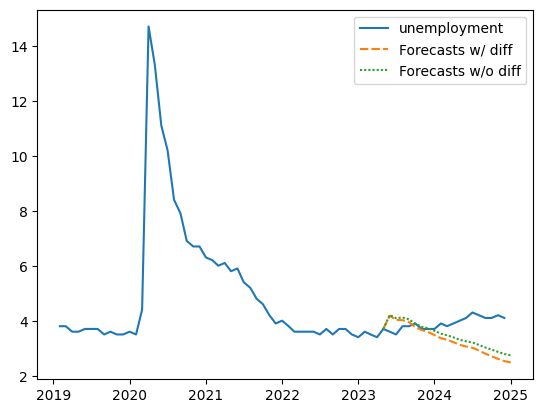

In [74]:
varplot = 0
f = pd.DataFrame({'Forecasts w/ diff': ff[:,1],'Forecasts w/o diff': ffn[:,1]}, index=pd.date_range(start=df_y.index[-20]+pd.DateOffset(months=1), periods=20, freq='MS'))
f.loc[df_y.index[-20]] = df_y.loc[df_y.index[-20]][varplot]
df_f = pd.concat((df_y.iloc[:,varplot], f), axis=1)
sns.lineplot(df_f.iloc[-72:])

<Axes: >

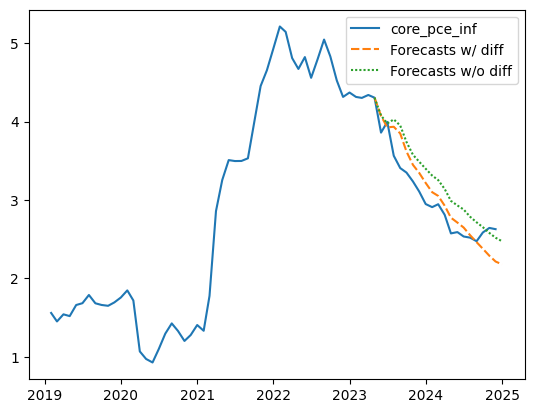

In [143]:
df_y

,unemployment,core_pce_inf,core_pce_real,interest,consumer_sentiment
date,,,,,
1990-01-01,5.3,3.554443,3.628883,8.23,-4.9
1990-02-01,5.3,3.796204,3.419743,8.24,-5.9
1990-03-01,5.2,4.058765,3.419743,8.28,-3.0
1990-04-01,5.4,4.132539,2.599765,8.26,2.4
1990-05-01,5.3,4.219775,2.702571,8.18,-0.1
...,...,...,...,...,...
2024-08-01,4.2,2.519058,3.553351,5.33,-1.6
2024-09-01,4.1,2.473375,3.347274,5.13,2.2
2024-10-01,4.1,2.585111,3.450519,4.83,6.7
